In [16]:
import optuna
from optuna.trial import TrialState

import pandas as pd
import torch
import datetime
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import optim
from sklearn.preprocessing import OneHotEncoder

import utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

# Подготовка данных

In [3]:
class ChurnDataset(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.tensor):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        data = self.x[index]
        label = self.y[index]
        return data, label

    def __len__(self):
        return len(self.x)

In [4]:
dataframe = pd.read_csv('telecom_churn.csv')
dataframe['Area code'] = dataframe['Area code'].astype(str)
OUTPUT_COLUMN = 'Churn'
to_drop = ['State']
categorical = ['Area code', 'International plan', 'Voice mail plan']

dataframe = utils.preprocess_df(dataframe, OUTPUT_COLUMN, categorical, to_drop= to_drop, resample=True)

# Датафрейм в тензор
x = torch.tensor(dataframe.drop(columns=OUTPUT_COLUMN).to_numpy()).to(device=device, dtype=torch.float)
encoder = OneHotEncoder()
y = encoder.fit_transform(dataframe[[OUTPUT_COLUMN]]).toarray()
y = torch.tensor(y).to(device=device, dtype=torch.float)

dataset = ChurnDataset(x, y)
train_dataset, validation_dataset, test_dataset = random_split(dataset, (0.8, 0.1, 0.1))
train_dataloader, validation_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=8), DataLoader(validation_dataset, batch_size=len(validation_dataset)), DataLoader(test_dataset, batch_size=len(test_dataset))

# Подготовка модели

In [5]:
class MyModel(nn.Module):
    """
    Класс для модели многослойного персептрона
    """
    def __init__(self, n_layers, in_features, hidden_features, out_features):
        super().__init__()
        if n_layers < 1:
            raise Exception("Incorrect number of layers")
        self.layers = []
        if n_layers == 1:
            self.layers.append(nn.Linear(in_features, out_features))
            self.layers.append(nn.Softmax())
        else:
            for i in range(n_layers):
                if i == 0:
                    layer = nn.Linear(in_features, hidden_features)
                    activation = nn.Tanh()

                elif i == n_layers - 1:
                    layer = nn.Linear(hidden_features, out_features)
                    activation = nn.Softmax()
                else:
                    layer = nn.Linear(hidden_features, hidden_features)
                    activation = nn.Tanh()
                self.layers.append(layer.to(device=device))
                self.layers.append(activation)
        self.run = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.run(x)
        

In [11]:
def training_loop(n_epochs, optimizer, scheduler, model, loss_fn, train_loader, validation_loader, ):
    best_score = 0
    counter = 0
    for epoch in range(n_epochs):
        for data, label in train_loader:
            output = model(data)
            loss = loss_fn(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        summary_loss = 0
        for data, label in validation_loader:
                  
            output = model(data)
            
            validation_score = utils.get_classification_metrics(label.argmax(1).cpu(), output.argmax(1).cpu())['Accuracy']



        if best_score > validation_score:
            counter += 1
            if counter == 5:
                print(f"Early stop on epoch {epoch}")
                break
        else:
            counter = 0
            best_score = validation_score

        if epoch == 1 or epoch % 5 == 0:

            print('{} Epoch {}, Training loss {}, Validation accuracy {}, lr {}'.format(
                datetime.datetime.now(),
                epoch,
                loss / len(train_loader),
                validation_score,
                scheduler.get_last_lr())
            )

# Подбор параметров

In [7]:
def objective(trial: optuna.Trial):

    in_features = len(dataframe.columns) - 1 # Один из столбцов таблицы является выходным 
    out_features = len(torch.unique(dataset.y))  
    hidden_features = trial.suggest_int("hidden_features", 5, 50, step=5)
    n_layers = trial.suggest_int("n_layers", 1, 4)
    model = MyModel(n_layers, in_features, hidden_features, out_features).to(device=device)
    
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=1e-2)
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30)
    loss_fn = torch.nn.CrossEntropyLoss()
    N_EPOCH = 100
    for epoch in range(N_EPOCH):
        model.train()
        for data, label in train_dataloader:
            output = model(data)
            loss = loss_fn(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        lr_scheduler.step()
        model.eval()

        for data, label in validation_dataloader:
                  
            output = model(data)
            validation_score = utils.get_classification_metrics(label.argmax(1).cpu(), output.argmax(1).cpu())['Accuracy']

        
        trial.report(validation_score, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return validation_score

In [8]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2024-04-29 16:46:34,651] A new study created in memory with name: no-name-91b593a2-63c6-4377-91fc-d6318fc16c35
[I 2024-04-29 16:49:07,376] Trial 0 finished with value: 0.8106194690265487 and parameters: {'hidden_features': 10, 'n_layers': 3, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8106194690265487.
[I 2024-04-29 16:51:21,575] Trial 1 finished with value: 0.8035398230088495 and parameters: {'hidden_features': 40, 'n_layers': 2, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8106194690265487.
[I 2024-04-29 16:54:16,920] Trial 2 finished with value: 0.8743362831858407 and parameters: {'hidden_features': 10, 'n_layers': 4, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.8743362831858407.
[I 2024-04-29 16:56:42,480] Trial 3 finished with value: 0.8831858407079646 and parameters: {'hidden_features': 25, 'n_layers': 2, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.8831858407079646.
[I 2024-04-29 16:58:26,483] Trial 4 finished with value: 0.7982300884955752 and p

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  88
  Number of complete trials:  12
Best trial:
  Value:  0.8867256637168142
  Params: 
    hidden_features: 50
    n_layers: 2
    optimizer: RMSprop


In [26]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  88
  Number of complete trials:  12
Best trial:
  Value:  0.8867256637168142
  Params: 
    hidden_features: 50
    n_layers: 2
    optimizer: RMSprop


In [33]:
in_features = len(dataframe.columns) - 1 # Один из столбцов таблицы является выходным
print(f"Число входных признаков - {in_features}")
out_features = len(torch.unique(dataset.y))
print(f"Число выходных признаков - {out_features}")
# Гиперпараметры модели, полученные выше
n_layers = 2 
hidden_features = 50
N_EPOCH = 100

model = MyModel(n_layers, in_features, hidden_features, out_features).to(device=device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30)
loss_fn = torch.nn.CrossEntropyLoss()

training_loop(N_EPOCH, optimizer, lr_scheduler, model, loss_fn, train_dataloader, validation_dataloader)
torch.save(model.state_dict(), f"MyModel.pt")

Число входных признаков - 19
Число выходных признаков - 2
2024-04-29 19:22:16.148257 Epoch 0, Training loss 0.0007105621625669301, Validation accuracy 0.7433628318584071, lr [0.01]
2024-04-29 19:22:17.501575 Epoch 1, Training loss 0.0006625524256378412, Validation accuracy 0.8053097345132744, lr [0.01]
2024-04-29 19:22:22.830602 Epoch 5, Training loss 0.0005580703727900982, Validation accuracy 0.8584070796460177, lr [0.01]
2024-04-29 19:22:29.483512 Epoch 10, Training loss 0.0005543644074350595, Validation accuracy 0.8619469026548673, lr [0.01]
2024-04-29 19:22:36.128645 Epoch 15, Training loss 0.0005534695810638368, Validation accuracy 0.8672566371681416, lr [0.01]
2024-04-29 19:22:42.747544 Epoch 20, Training loss 0.0005536751123145223, Validation accuracy 0.8601769911504424, lr [0.01]
Early stop on epoch 22


In [34]:
# Результаты из предыдущей практической работы
results = {'Метод опорных векторов': 0.909,
 'Дерево решений': 0.8796886058032555,
 'Обрезанное дерево решений': 0.9263977353149327,
 'Бэггинг': 0.940552016985138,
 'Бустинг': 0.940552016985138,
 'Стекинг': 0.9532908704883227}

In [35]:

for data, label in test_dataloader:
    label = label.argmax(1)
    predicted = model(data).argmax(1)
    #print(label == predicted)
    score = utils.get_classification_metrics(label.cpu(), predicted.cpu())
    results['Многослойный персептрон'] = score['Accuracy']
    print(score)

{'Accuracy': 0.8831858407079646, 'Precision': 0.9362549800796812, 'Recall': 0.8245614035087719, 'F1': 0.8768656716417911, 'Roc auc score': 0.8837092731829573}


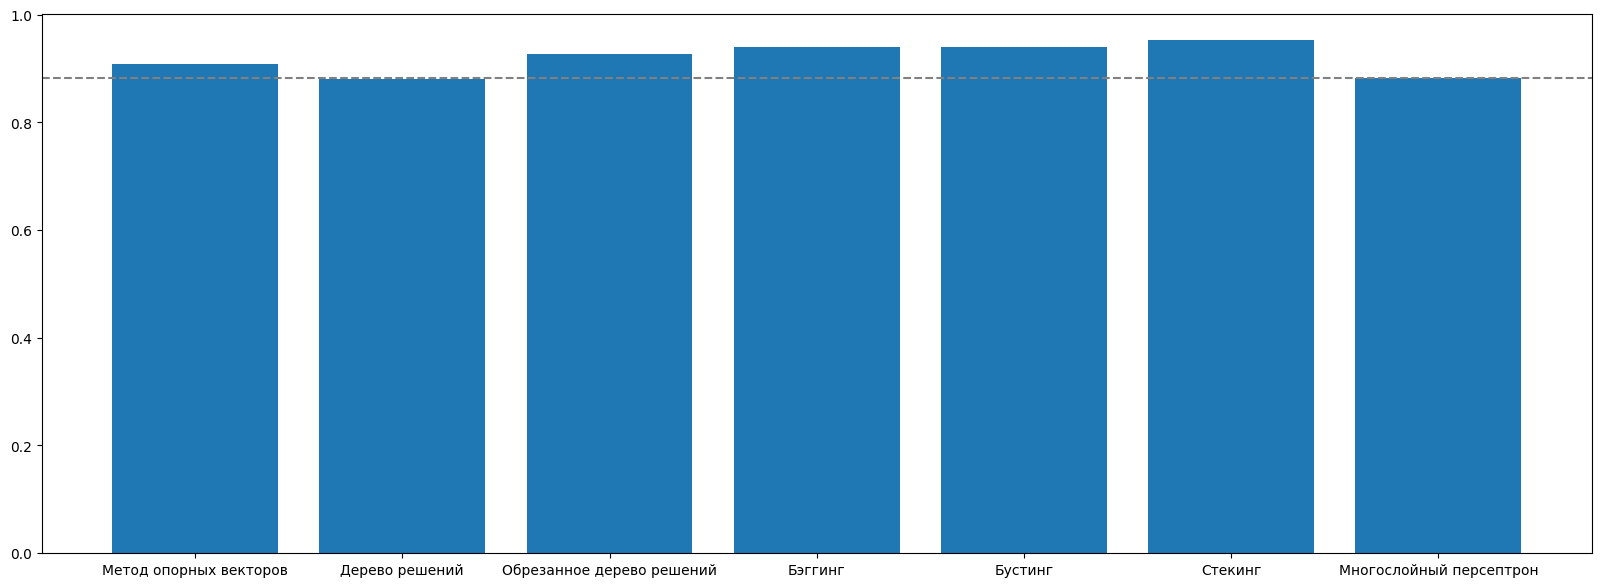

In [36]:
plt.figure(figsize=(20, 7))
plt.axhline(results['Многослойный персептрон'], linestyle='--', color='grey', label='123')
plt.bar(results.keys(), results.values())
plt.show()